# Wine Price Prediction

First attempt at the price prediction for wine. I am trying to use the information leveraged from fastai to see if I can get some basic insight on the subject. Also since the fastai libraries has support for lr_find and SGD with restarts it might be a good start

### Issues
* One issue is that fastai does not do linear regression kind of predictions(might have to look into there source more)
* Data format is different here since we dont have a test/train/validation set so had to use from_arrays instead of from_csvs 
* Had to modify the problem as a classification problem

### Obligatory imports

In [1]:
from fastai.conv_learner import *
import os

Global variables defining path etc

In [2]:
PATH = 'data/wine/'
ARCH=resnet34
FOLDER='train'
CSVNAME='wine_prices.csv'
BATCHSIZE=32

## Look at the data

In [14]:
df = pd.read_csv(os.path.join(PATH, CSVNAME)); df[:30]

,id,Name,Image,Varietal,Price Impression
0,b01028-cr-vcab-fn10nn-r11-t11_2018-01-a,10 Span Cabernet Sauvignon,b01028-cr-vcab-fn10nn-r11.png,vcab,12.89
1,la170036-cr-vcab-r10-n00048-r10_2017-03-a,14 Hands Cabernet Sauvignon,la170036-cr-vcab-r10-n00048.jpg,vcab,11.30
2,la170240-cr-vcab-r14-n06662-r14_2017-07-a,Antares Cabernet Sauvignon,la170240-cr-vcab-r14-n06662.png,vcab,16.52
3,ba1523-cr-vcab-fn10nn-r07-t07_2018-01-a,Arrow Creek Cabernet Sauvignon,ba1523-cr-vcab-fn10nn-r07.png,vcab,6.13
4,la180234-cr-vcab-r11-n00743-r11_2017-07-a,Avalon Cabernet Sauvignon,la180234-cr-vcab-r11-n00743.png,vcab,13.82
5,rp100141-p14_2016-06-a,Avalon Cabernet Sauvignon Napa,rp100141.jpg,vcab,11.87
6,la170043-cr-vcab-r05-n00080-r05_2017-03-a,Barefoot Cellars Cabernet Sauvignon,la170043-cr-vcab-r05-n00080.jpg,vcab,5.49
7,la170051-cr-vcab-r07-n00129-r07-2017-03-b,Beaulieu Vineyard Bv Coastal,la170051-cr-vcab-r07-n00129.png,vcab,8.39
8,rp100406-p14_2016-06-a,Ben Ami Cabernet Sauvignon,rp100406.jpg,vcab,19.19
9,la170007-cr-vcab-r04-n00119-r04_2017-03-a,Beringer Cabernet Sauvignon,la170007-cr-vcab-r04-n00119.png,vcab,8.62


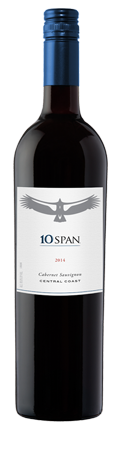

In [4]:
img=Image.open(os.path.join(PATH, df.Image[0]))
background = Image.new('RGBA', img.size, (255,255,255))
cimg=Image.alpha_composite(background, img)
cimg.convert(mode='RGB')
cimg

In [5]:
import PIL

In [6]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

### Issue I ran into:
1. All images are not the same size:Solution: Ignore the images smaller that 400(only 1 image is in that size)
2. Some file were missing: Solution: modified the script to handle that
3. Some files were named wrong(jpg vs png): Modified the csv file to fix that
4. PNG is 4 channels vs JPEG is 3 channels, tried to use image.convert...not sure what to do

In [7]:
img_data=[]
price_data=[]
conv_to_tensor = torchvision.transforms.ToTensor()

for i in range(len(df)):
    fname=os.path.join(PATH, df.Image[i])
    if os.path.isfile(fname):
        img = PIL.Image.open(fname)
        if img.mode == 'RGBA':
            background = Image.new('RGBA', img.size, (255,255,255))
            cimg=Image.alpha_composite(background, img)
            cimg = cimg.convert(mode='RGB')
        else:
            cimg = img
        tensor = np.asarray(cimg)
        #print(img.getbands(), tensor.shape)
        if tensor.shape[0] > 400:
            img_data.append(tensor)
            price_data.append([df['Price Impression'][i], 0])
        else:
            print("File %s has small image size of %d" %(fname, tensor.shape[1]))
    else:
        print("File %s not found for index %d" %(fname, i))

File data/wine/la170007-cr-vcab-r04-n00119.png not found for index 9
File data/wine/rp100589-png not found for index 28
File data/wine/rp320021.png has small image size of 90


Find the smallest dimension and crop the images so that all are the same dimensions

In [8]:
mindim=min([ img.shape for img in img_data]); mindim

(443, 120, 3)

In [9]:
for i in range(len(img_data)):
    img = img_data[i]
    if img.shape[0] > mindim[0]:
        img_data[i] = img[:mindim[0], :, :]

Sort the images by price

In [10]:
datas = list(zip(img_data, price_data))
datas.sort(key=lambda x: x[1][0])
img_data, price_data = zip(*datas)

Generate class data from the pricing. *THIS IS A HACK* to work with fastai!!!

In [11]:
nclasses = 5
xClass = 0
size = int(len(datas)/nclasses) + 1
for i in range(len(price_data)):
    if (i + 1) % size == 0:
        xClass = xClass + 1
    price_data[i][1] = 2**xClass

Least expensive wines

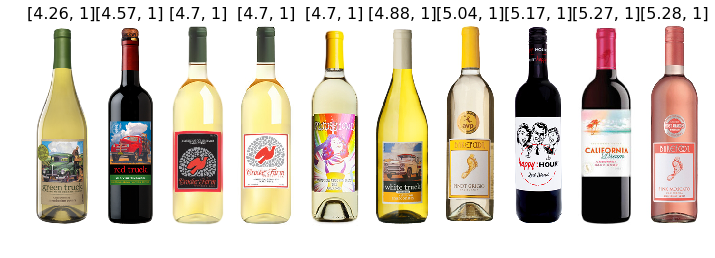

In [12]:
plots(img_data[:10], titles=price_data[:10])

Most expensive wines

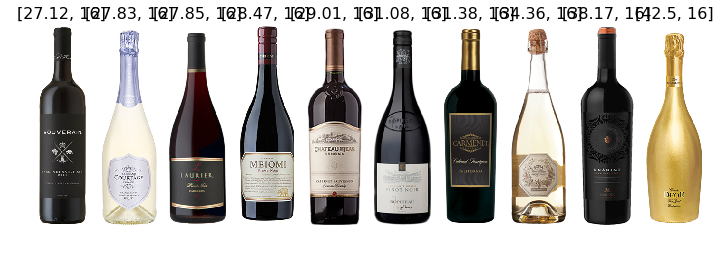

In [13]:
plots(img_data[-10:], titles=price_data[-10:])

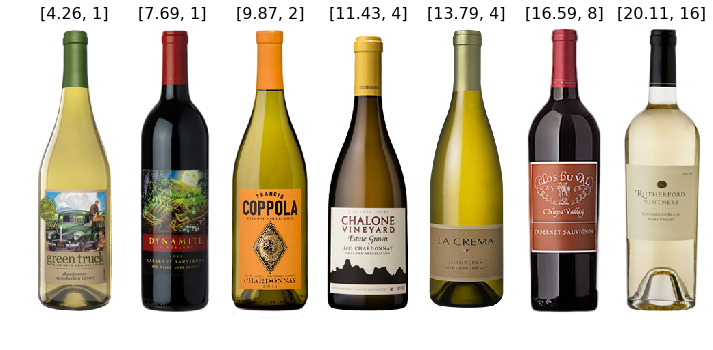

In [15]:
plots(img_data[0:-1:80], titles=price_data[0:-1:80])

Randomize the dataset, using shuffle to do this

In [16]:
from sklearn.utils import shuffle

In [17]:
img_data, price_data = shuffle(img_data, price_data)

Split the price and class, this is for simplifying the information

In [18]:
val_data, class_data = list(zip(*price_data))

Some random samples

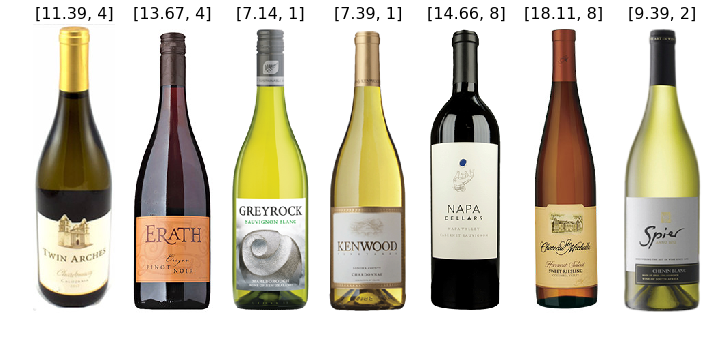

In [19]:
plots(img_data[-7:], titles=price_data[-7:])

In [20]:
img_data=np.stack(img_data)

In [21]:
trn_data=(np.array(img_data[:400]), np.array(class_data[:400]))
val_data=(np.array(img_data[400:500]), np.array(class_data[400:500]))
test_data=(np.array(img_data[500:]), np.array(class_data[500:]))

In [22]:
trn_data[0][2].shape

(443, 120, 3)

In [23]:
def get_data(size, batchsize, trn, val, test):
    tfms = tfms_from_model(ARCH, size, max_zoom=1.1, aug_tfms=transforms_top_down)
    return ImageClassifierData.from_arrays(PATH, trn, val, bs=batchsize, tfms=tfms, test=test)

In [24]:
data=get_data(64, BATCHSIZE, trn_data, val_data, test_data)

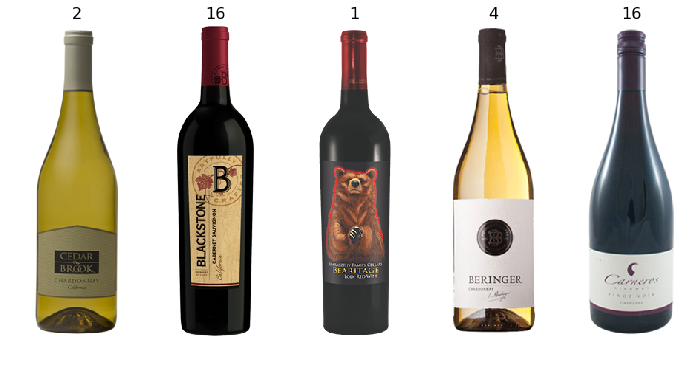

In [25]:
plots(data.val_ds.x[:5], titles=data.val_y[:5])

In [26]:
learn=ConvLearner.pretrained(ARCH, data, precompute=True)

/home/bhaskar/MyCode/fastai/courses/dl1/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [29]:
learn.fit(0.1, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      2.494142   6.010016   0.22      
    1      3.29833    5.467138   0.18                    
    2      3.701375   4.242367   0.17                    
    3      3.488967   2.485308   0.21                     
    4      3.087662   2.09367    0.22                     



[2.09366979598999, 0.22]

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 

In [ ]:
learn.fit(lr, 5)

In [ ]:
learn.precom